# Calculation of isoprenol concentrations for different strain designs

Tested using **biodesign_3.7** kernel on the jprime.lbl.gov server. It uses the cplex library for running the MOMA optimization

#### The two files that are necessary for the notebook to run are:
   - A modified E. coli model with the isopentenol pathway added to it (`iJO1366_MVA.json` file in the `../data/models` directory)
   - A set of designs (e.g. `../data/ice_mo_strains.csv` exported from ICE) containing the details of which reactions are either:
       - (0) eliminated 
       - (1) included
       - (2) doubled the flux

#### Running the cells below will generate the following output files for EDD import:

- `experiment_description_file.csv`
- `isoprenol_production.csv`
    

## Setup

Clone the git repository with the `OMG` library:

`git clone https://github.com/JBEI/OMG.git --branch omgforallhosts --single-branch`

or pull the latest version.

In [50]:
import sys
import os

sys.path.insert(1, '../../OMG')
sys.path.append('../')

import cobra
import pandas as pd
import omg 
from plot import *


## User parameters

In [3]:
user_params = {
    'host': 'ecoli', # ecoli or ropacus
    'modelfile': '../data/models/iJO1366_MVA.json',
    'cerevisiae_modelfile': '../data/models/iMM904.json',
    'timestart': 0.0,
    'timestop': 8.0,
    'numtimepoints': 9,
    'designsfile': 'ice_mo_strains.csv',
    'designsfilepath': '../data/',
    'mapping_file': '../mapping/inchikey_to_cid.txt',
    'output_file_path': '../data/omg_output',
    'edd_omics_file_path': '../data/omg_output/edd/',
    'numreactions': 8,
    'numinstances': 96,
    'ext_metabolites': {
        'glc__D_e': 22.203,
        'nh4_e': 18.695,
        'pi_e': 69.454,
        'so4_e': 2.0,
        'mg2_e': 2.0,
        'k_e': 21.883,
        'na1_e': 103.7,
        'cl_e': 27.25,
        'isoprenol_e': 0.0,
        'ac_e': 0.0,
        'for_e': 0.0,
        'lac__D_e': 0.0,
        'etoh_e': 0.0
    },
    'initial_OD': 0.01,
    'BIOMASS_REACTION_ID': 'BIOMASS_Ec_iJO1366_core_53p95M'
} 

## Using the OMG library functions for creating synthetic multiomics data

### 1) Getting and preparing the metabolic model

First we obtain the metabolic model:

In [4]:
file_name = user_params['modelfile']
model = cobra.io.load_json_model(file_name)

#### Check if isopentenol pathway is present in the model, else add it using the *S. Cerevisiae* model

In [5]:
if not omg.model_has_IPP_pathway(model):
    print("Isopentenol pathway is present in the model")
    sce_filename = user_params['cerevisiae_modelfile']
    try:
        sce_model = cobra.io.load_json_model(sce_filename)
    except IOError:
        print("Could not read file:", sce_filename)
    else:
        # add pathway to model
        omg.add_isopentenol_pathway(model, sce_model)

We now add minimum flux constraints for production of isopentenol and formate, and we limit oxygen intake:

In [6]:
iso = 'EX_isoprenol_e'
iso_cons = model.problem.Constraint(model.reactions.EX_isoprenol_e.flux_expression,lb = 0.20)
model.add_cons_vars(iso_cons)
for_cons = model.problem.Constraint(model.reactions.EX_for_e.flux_expression,lb = 0.10)
model.add_cons_vars(for_cons)
o2_cons = model.problem.Constraint(model.reactions.EX_o2_e.flux_expression,lb = -8.0)
model.add_cons_vars(o2_cons)


And then we constrain several central carbon metabolism fluxes to more realistic upper and lower bounds:

In [7]:
CC_rxn_names = ['ACCOAC','MDH','PTAr','CS','ACACT1r','PPC','PPCK','PFL']
for reaction in CC_rxn_names:
    reaction_constraint = model.problem.Constraint(model.reactions.get_by_id(reaction).flux_expression,lb = -1.0,ub =  1.0)
    model.add_cons_vars(reaction_constraint)

We also create a similar model with a higher production of isopentenol, which we will use with MOMA to simulate bioengineered strains:

In [8]:
modelHI = model.copy()
iso_cons = modelHI.problem.Constraint(modelHI.reactions.EX_isoprenol_e.flux_expression,lb = 0.25)
modelHI.add_cons_vars(iso_cons)

### 2) Obtaining times series

Create first time grid for simulation:

In [9]:
t0 = user_params['timestart']
tf = user_params['timestop']
points = user_params['numtimepoints']
tspan, delt = np.linspace(t0, tf, points, dtype='float64', retstep=True)

grid = (tspan, delt)

We then use this model to obtain the times series for fluxes, OD and external metabolites:

In [10]:
solution_TS, model_TS, cell, Emets, Erxn2Emet = \
    omg.get_flux_time_series(model, user_params['ext_metabolites'], grid, user_params)

0.0 optimal 0.5363612610171437
1.0 optimal 0.5363612610171437
2.0 optimal 0.5363612610171437
3.0 optimal 0.5363612610171437
4.0 optimal 0.5363612610171437
5.0 optimal 0.5363612610171437
6.0 optimal 0.5363612610171437
7.0 optimal 0.5363612610171437
8.0 optimal 0.5363612610171437


We perform the same calculation for the model with higher isoprenol production that we created above:

In [11]:
solutionHI_TS, modelHI_TS, cellHI, EmetsHI, Erxn2EmetHI = \
    omg.get_flux_time_series(modelHI, user_params['ext_metabolites'], grid, user_params)

0.0 optimal 0.5352266385352652
1.0 optimal 0.5352266385352652
2.0 optimal 0.5352266385352652
3.0 optimal 0.5352266385352652
4.0 optimal 0.5352266385352652
5.0 optimal 0.5352266385352652
6.0 optimal 0.5352266385352652
7.0 optimal 0.5352266385352652
8.0 optimal 0.5352266385352652


### 3) Getting bioengineered flux profiles through MOMA

First obtain the file from ICE with suggested designs (i.e. reactions kos and overexpressions):

In [12]:
designs_df = pd.read_csv(f'{user_params["designsfilepath"]}/{user_params["designsfile"]}',
                        usecols=['Part ID', 'Name', 'Summary'])
designs_df.columns = ['Part ID','Line Name','Line Description']
designs_df[:2]

,Part ID,Line Name,Line Description
0,ABFPUB_000215,Strain 1,ACCOAC_1.0_MDH_1.0_PTAr_2.0_CS_0.0_ACACT1r_2.0...
1,ABFPUB_000216,Strain 2,ACCOAC_1.0_MDH_2.0_PTAr_2.0_CS_2.0_ACACT1r_2.0...


Save the `experiment_description_file.csv` for EDD import:

In [13]:
experiment_description_file_name = f'{user_params["edd_omics_file_path"]}/experiment_description_file.csv'

with open(experiment_description_file_name, 'w') as fh:
    fh.write('Part ID, Line Name, Line Description, Media, Shaking Speed, Starting OD, Culture Volume, Flask Volume, Growth Temperature, Replicate Count\n')
    for i in range(len(designs_df)):
        fh.write(f"{designs_df.loc[i]['Part ID']}, \
                 {designs_df.loc[i]['Line Name']}, \
                 {designs_df.loc[i]['Line Description']}, \
                 M9, 1, 0.1, 50, 200, 30, 1\n")
   

Read information from Line Description and store into separate columns:

In [14]:
# Add columns for each reaction
reactions = designs_df['Line Description'][0].split('_')[::2]
for rxn in reactions:
    designs_df[rxn] = None

# And assign values for each reaction and line
for i in range(len(designs_df)):
    if designs_df['Line Name'][i]=='WT':
        designs_df.loc[i][reactions] = [1 for r in range(len(reactions))]
    else:
        values = designs_df.loc[i]['Line Description'].split('_')[1::2]
        designs_df.loc[i][reactions] = [float(value) for value in values]

designs_df = designs_df.drop(columns='Line Description')

Each design (line) involves the modification of up to 8 fluxes (1 -> keep the same; 2-> double flux, 0-> knock reaction out):

In [15]:
designs_df.tail()

,Part ID,Line Name,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
91,ABFPUB_000306,Strain 92,0,0,2,2,0,2,0,2
92,ABFPUB_000307,Strain 93,1,2,0,0,0,2,2,0
93,ABFPUB_000308,Strain 94,0,2,0,1,0,2,1,1
94,ABFPUB_000309,Strain 95,0,1,2,0,1,1,0,2
95,ABFPUB_000310,WT,1,1,1,1,1,1,1,1


We then use MOMA to calculate flux profiles at each time point for the bioengineered strains. Instead of using the solution time series corresponding to the initial model, we use the solution time series corresponding to the higher production. The reason is that, otherwise, we would never see an increase in isoprenol production, since MOMA minimizes the changes in flux by design. Remember that our goal here is just to create realistic flux profiles that can be used to showcase ART. This approach is good enough: 

In [38]:
%%time
solutionsMOMA_TS = {}
cols = ['Line Name']
cols.extend(reactions)

if user_params['numinstances'] not in [None, 0]:
    num_strains = user_params['numinstances']
else:
    num_strains = design_df.shape[0]

for i in range(num_strains):
    design = designs_df[cols].loc[i]
    if design['Line Name']=='WT':
        solutionsMOMA_TS[i] = omg.getBEFluxes(model_TS, design, solution_TS, grid)
    else:
        solutionsMOMA_TS[i] = omg.getBEFluxes(model_TS, design, solutionHI_TS, grid)

CPU times: user 1h 35min 57s, sys: 41.2 s, total: 1h 36min 38s
Wall time: 1h 36min 49s


We can check that the knocked out fluxes are zero:

In [39]:
i = 0
print(designs_df.loc[i,:], '\n')
for rxn in ['CS','PPC','PPCK','PFL']:
    print(f'{rxn}: {solutionsMOMA_TS[i][5].fluxes[rxn]}')

Part ID      ABFPUB_000215
Line Name         Strain 1
ACCOAC                   1
MDH                      1
PTAr                     2
CS                       0
ACACT1r                  2
PPC                      0
PPCK                     0
PFL                      0
Name: 0, dtype: object 

CS: 0.0
PPC: 0.0
PPCK: 0.0
PFL: 0.0


### 4) Producing the external metabolite concentrations for each bioengineered strain 

Here we use the `integrate_fluxes` function to produce the external metabolite concentrations compatible with the calculated fluxes:

In [40]:
%%time
cellsEmetsBE = {}
for i in range(num_strains):
    cell, Emets = omg.integrate_fluxes(solutionsMOMA_TS[i], model_TS, user_params['ext_metabolites'], grid, user_params)
    cellsEmetsBE[i] = (cell, Emets) 


CPU times: user 2.28 s, sys: 36 ms, total: 2.32 s
Wall time: 2.32 s


We can check we obtain the same result with this function for the wild type as we did before in notebook A:

In [41]:
cellWT, EmetsWT = omg.integrate_fluxes(solution_TS, model_TS, user_params['ext_metabolites'], grid, user_params)

In [42]:
EmetsWT

,glc__D_e,nh4_e,pi_e,so4_e,mg2_e,k_e,na1_e,cl_e,isoprenol_e,ac_e,for_e,lac__D_e,etoh_e
0.0,22.0707,18.6183,69.4472,1.99821,1.99994,21.8816,103.7,27.25,0.00264663,0.027405,0.00132331,0.102538,0
1.0,21.8444,18.4873,69.4354,1.99515,1.99983,21.8792,103.7,27.2499,0.00717176,0.0742613,0.00358588,0.277855,0
2.0,21.4576,18.2632,69.4154,1.98992,1.99965,21.8752,103.7,27.2498,0.0149087,0.154375,0.00745436,0.577608,0
3.0,20.7961,17.88,69.3812,1.98097,1.99935,21.8683,103.7,27.2496,0.0281372,0.291351,0.0140686,1.09012,0
4.0,19.6653,17.2248,69.3227,1.96567,1.99882,21.8564,103.7,27.2493,0.0507548,0.52555,0.0253774,1.96639,0
5.0,17.7317,16.1047,69.2227,1.93951,1.99792,21.8362,103.7,27.2488,0.0894259,0.925977,0.044713,3.46462,0
6.0,14.4258,14.1895,69.0516,1.89479,1.99638,21.8016,103.7,27.2478,0.155545,1.61062,0.0777724,6.02626,0
7.0,8.77335,10.915,68.7592,1.81833,1.99375,21.7424,103.7,27.2463,0.268593,2.7812,0.134297,10.4061,0
8.0,0,5.31631,68.2591,1.68759,1.98925,21.6412,103.7,27.2436,0.46188,4.78262,0.23094,17.8946,0
9.0,0,5.31631,68.2591,1.68759,1.98925,21.6412,103.7,27.2436,0.46188,4.78262,0.23094,17.8946,0


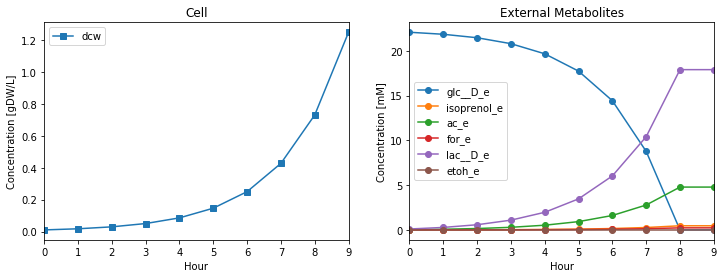

In [43]:
plot_DO_extmets(cellWT, EmetsWT[['glc__D_e','isoprenol_e','ac_e','for_e','lac__D_e','etoh_e']])

And compare with any other bioengineered strain:

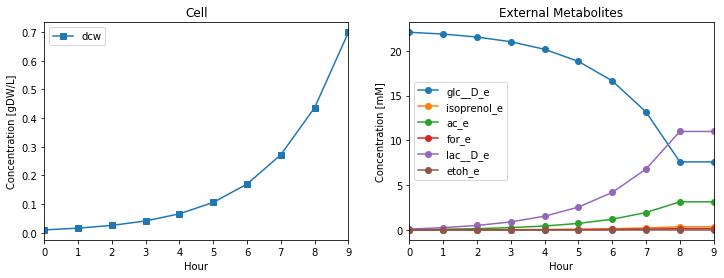

In [44]:
i = 2
cellBE, EmetsBE = cellsEmetsBE[i]
plot_DO_extmets(cellBE, EmetsBE[['glc__D_e','isoprenol_e','ac_e','for_e','lac__D_e','etoh_e']])

In [45]:
EmetsBE

,glc__D_e,nh4_e,pi_e,so4_e,mg2_e,k_e,na1_e,cl_e,isoprenol_e,ac_e,for_e,lac__D_e,etoh_e
0.0,22.0752,18.6209,69.4481,1.99814,1.99995,21.8818,103.7,27.25,0.00305532,0.0274419,0.00127792,0.0961986,0
1.0,21.8703,18.5022,69.4387,1.99517,1.99986,21.8799,103.7,27.2499,0.00795333,0.0714341,0.00332657,0.250415,0
2.0,21.5419,18.3118,69.4236,1.99039,1.99973,21.8769,103.7,27.2498,0.0158052,0.141958,0.00661077,0.497641,0
3.0,21.0154,18.0067,69.3994,1.98274,1.99951,21.8721,103.7,27.2497,0.0283926,0.255016,0.0118757,0.893971,0
4.0,20.1714,17.5175,69.3606,1.97048,1.99917,21.8643,103.7,27.2495,0.048572,0.436261,0.0203159,1.52933,0
5.0,18.8183,16.7333,69.2984,1.95081,1.99861,21.8518,103.7,27.2492,0.0809214,0.726815,0.0338466,2.54788,0
6.0,16.6492,15.4761,69.1986,1.91929,1.99773,21.8318,103.7,27.2486,0.132781,1.1926,0.0555376,4.18072,0
7.0,13.1719,13.4607,69.0388,1.86876,1.9963,21.7998,103.7,27.2478,0.215919,1.93931,0.0903106,6.79835,0
8.0,7.59744,10.2297,68.7824,1.78775,1.99402,21.7485,103.7,27.2464,0.349196,3.13637,0.146056,10.9947,0
9.0,7.59744,10.2297,68.7824,1.78775,1.99402,21.7485,103.7,27.2464,0.349196,3.13637,0.146056,10.9947,0


### 5) Creating file with isoprenol concentrations for EDD import and training ART

Collect all isoprenol production values in a single list first:

In [46]:
production = []
for i in range(user_params['numinstances']):
    cell, Emets = cellsEmetsBE[i]
    production.append(Emets.loc[user_params['numtimepoints'],'isoprenol_e'])

Create new data frame and append the production

In [72]:
production_df = designs_df.copy()
production_df.head()

,Part ID,Line Name,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL
0,ABFPUB_000215,Strain 1,1,1,2,0,2,0,0,0
1,ABFPUB_000216,Strain 2,1,2,2,2,2,1,1,0
2,ABFPUB_000217,Strain 3,1,0,0,2,1,1,2,0
3,ABFPUB_000218,Strain 4,1,1,1,1,2,2,1,0
4,ABFPUB_000219,Strain 5,2,0,2,1,1,0,1,1


In [73]:
production_df['Isoprenol'] = pd.Series(production)
production_df.loc[0:2,:]

,Part ID,Line Name,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Isoprenol
0,ABFPUB_000215,Strain 1,1,1,2,0,2,0,0,0,0.000000
1,ABFPUB_000216,Strain 2,1,2,2,2,2,1,1,0,0.552101
2,ABFPUB_000217,Strain 3,1,0,0,2,1,1,2,0,0.349196


In [74]:
np.max(production_df['Isoprenol'])

0.5726483723065023

**DO WE NEED PART ID COLUMN?**

In [75]:
# MELT THE DATAFRAME
production_edd_df = production_df.drop(columns=reactions).copy()
isoprenol_cid = 'CID:15983957'
production_edd_df = production_edd_df.rename(columns={'Isoprenol': isoprenol_cid})
production_edd_df = production_edd_df.set_index(['Part ID','Line Name']).stack().reset_index()
production_edd_df.columns = ['Part ID','Line Name', 'Measurement Type', 'Value']
production_edd_df['Time'] = 9.0
production_edd_df['Units'] = 'mg/L'
production_edd_df.head()

,Part ID,Line Name,Measurement Type,Value,Time,Units
0,ABFPUB_000215,Strain 1,CID:15983957,0.000000,9.0,mg/L
1,ABFPUB_000216,Strain 2,CID:15983957,0.552101,9.0,mg/L
2,ABFPUB_000217,Strain 3,CID:15983957,0.349196,9.0,mg/L
3,ABFPUB_000218,Strain 4,CID:15983957,0.551849,9.0,mg/L
4,ABFPUB_000219,Strain 5,CID:15983957,0.080117,9.0,mg/L


Save data frame as csv:

In [76]:
production_file_name = f'{user_params["edd_omics_file_path"]}/isoprenol_production.csv'
production_edd_df.to_csv(production_file_name)
